In [658]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import datetime

pd.options.display.max_columns = 8
pd.options.display.max_rows = 50

import matplotlib.pylab as plt
%matplotlib inline
import seaborn

In [659]:
def one_hot_encode(data, features):
    le = LabelEncoder()
    onehot = OneHotEncoder(sparse=False)
    for feature in features:
        data[feature] = le.fit_transform(data[feature])
        labels = le.classes_
        hot = onehot.fit_transform(np.array(data[[feature]]))
        temp = pd.DataFrame(hot, columns=[feature + '_' + str(label) for label in labels])
        if data[feature].dtype == object:
            data.drop(feature, axis=1, inplace=True)
        data = data.merge(temp, left_index=True, right_index=True)
    return data

## Data import

In [660]:
SOURCE_PATH = '../data/source/'
train = pd.read_excel(os.path.join(SOURCE_PATH, 'train.xlsx'), sheetname=1, encoding='utf-8')
test = pd.read_excel(os.path.join(SOURCE_PATH, 'test.xlsx'), sheetname=1, encoding='utf-8')

In [661]:
train['is_train'] = 1
test['is_train'] = 0
data = pd.concat([train, test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359572 entries, 0 to 177759
Data columns (total 26 columns):
ACTIVITY FILENAME__C         53243 non-null object
ACTIVITY_NAME                127367 non-null object
ACTIVITY_TYPE__C             126080 non-null object
CAMPAIGN.CAMPAIGN_CODE__C    237937 non-null object
CAMPAIGN.NAME                147682 non-null object
CAMPAIGN.SUB_TYPE__C         147667 non-null object
CAMPAIGN.TYPE                147682 non-null object
CAMPAIGN_DEPARTMENT          126386 non-null object
COMAPNYNAME                  147467 non-null object
CONTACT QUALIFICATION        10337 non-null object
CONTACT.QUALIFIEDDATE__C     10071 non-null object
COUNTRY                      354444 non-null object
CREATEDBYID                  148750 non-null object
DOMAIN                       359572 non-null object
EMAIL                        359572 non-null object
LEAD_CONTACT_CREATEDDATE     357770 non-null object
OPPORTUNITY CLOSEDATE        35195 non-null object
OPPORTUNI

## Preprocessing

### OPPORTUNITY STAGENAME - TARGET

In [662]:
data['target'] = data['OPPORTUNITY STAGENAME'].map(lambda x: int(x == 'Closed Won'))
if data.filter(like='OPP').shape[1] > 0:
    data.drop(train.filter(like='OPP').columns, axis=1, inplace=True)
    
# трейн пригодится для графиков
train['target'] = train['OPPORTUNITY STAGENAME'].map(lambda x: int(x == 'Closed Won'))

### KEY value, EMAIL and DOMAIN

In [663]:
print "Число уникальных доменов в трейне", len(train.DOMAIN.unique())
print "Число уникальных доменов в тесте", len(test.DOMAIN.unique())

if 'EMAIL' in data.columns:
    data['username'] = data.EMAIL.map(lambda x: x.split('@')[0])
    data.drop('EMAIL', axis=1, inplace=True)

Число уникальных доменов в трейне 22718
Число уникальных доменов в тесте 22357


###  zip_set
User zipcode

In [664]:
data.zip_set.describe()

count      120364
unique        380
top       ZS-6954
freq        10335
Name: zip_set, dtype: object

In [665]:
if 'zip_set' in data.columns:
    data['zipset_isnan'] = data.zip_set.isnull().astype(int)
    data.drop('zip_set', axis=1, inplace=True)

### State
User State

In [666]:
if 'State' in data.columns:
    data['State_isnan'] = data.State.isnull().astype(int)
    data.drop('State', axis=1, inplace=True)

### RECORD_CREATEDDATE
Datetime when user activity or sales activity has been logged in CRM

In [667]:
print "Число NaN в трейне", train.RECORD_CREATEDDATE.isnull().sum()
print "Число NaN в тесте", test.RECORD_CREATEDDATE.isnull().sum()

Число NaN в трейне 48
Число NaN в тесте 38


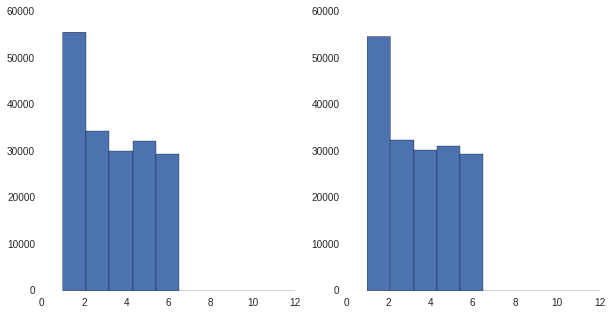

In [668]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train.RECORD_CREATEDDATE.map(lambda x: x.month).hist(ax=ax1)
test.RECORD_CREATEDDATE.map(lambda x: x.month).hist(ax=ax2)

In [669]:
data['rec_cd_month'] = data.RECORD_CREATEDDATE.map(lambda x: x.month)
data.rec_cd_month.fillna(-1, inplace=True)
if 'RECORD_CREATEDDATE' in data.columns:
    data.drop('RECORD_CREATEDDATE', axis=1, inplace=True)

### RECORD-TYPE
User activity (Customer_Activity/CampaignMember) or Sales activity (Task)

0 0


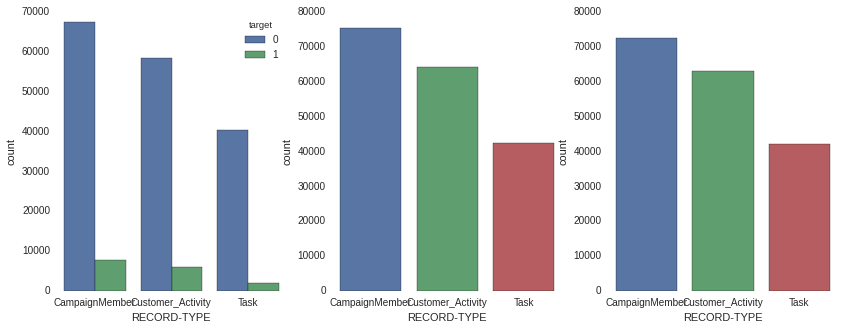

In [670]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
sns.countplot(x='RECORD-TYPE', data=train, ax=ax1, hue='target')
sns.countplot(x='RECORD-TYPE', data=train, ax=ax2)
sns.countplot(x='RECORD-TYPE', data=test, ax=ax3)
print train['RECORD-TYPE'].isnull().sum(), test['RECORD-TYPE'].isnull().sum()

In [671]:
if 'RECORD-TYPE' in data.columns:
    data = one_hot_ecncode(data, ['RECORD-TYPE'])
    data.drop('RECORD-TYPE', axis=1, inplace=True)

### PRODUCTLIST__C
Products related to user activity

In [672]:
data.PRODUCTLIST__C.describe()

count            71572
unique              17
top       Veeam Backup
freq             33885
Name: PRODUCTLIST__C, dtype: object

In [673]:
if 'PRODUCTLIST__C' in data.columns:
    data['productlist_isnan'] =  data.PRODUCTLIST__C.isnull().astype(int)
    data.drop('PRODUCTLIST__C', axis=1, inplace=True)

### LEAD_CONTACT_CREATEDDATE
Datetime when user was created in CRM

In [674]:
def parse_date(date, target='year'):
    if hasattr(date, target):
        return getattr(date, target)
    elif type(date) is str:
        if len(date.split(' ')[0].split('/')) == 3:
            if target == 'year':
                return int(date.split(' ')[0].split('/')[2])
            elif target == 'month':
                return int(date.split(' ')[0].split('/')[0])
        else:
            return np.nan

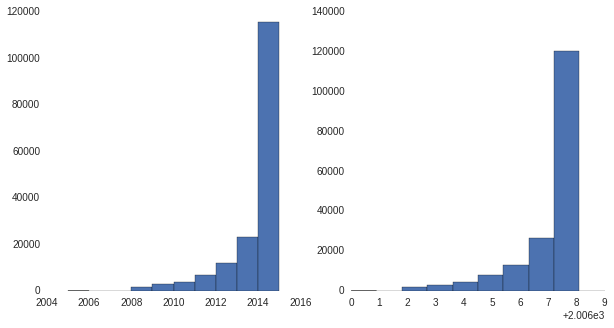

In [675]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x)).hist(ax=ax1)
test.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x)).hist(ax=ax2)

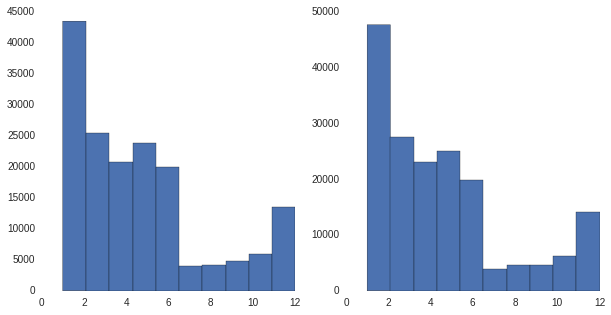

In [676]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
train.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x, target='month')).hist(ax=ax1)
test.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x, target='month')).hist(ax=ax2)

In [677]:
if 'LEAD_CONTACT_CREATEDDATE' in data.columns:
    data['lc_cd_month'] = data.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x, target='month'))
    data['lc_cd_year'] = data.LEAD_CONTACT_CREATEDDATE.map(lambda x: parse_date(x, target='year'))
    data.drop('LEAD_CONTACT_CREATEDDATE', axis=1, inplace=True)
data.lc_cd_month.fillna(-1, inplace=True)
data.lc_cd_year.fillna(-1, inplace=True)

### CREATEDBYID
Marketing platform ID which captured user activity

106207 104615


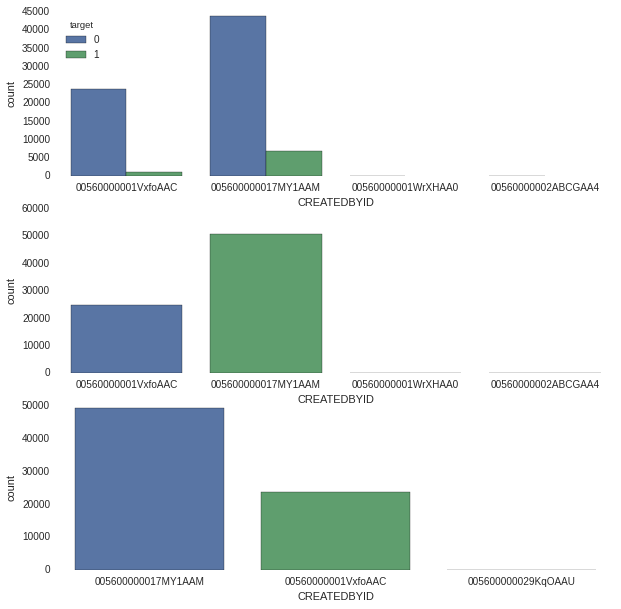

In [678]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))
sns.countplot(x='CREATEDBYID', data=train, ax=ax1, hue='target')
sns.countplot(x='CREATEDBYID', data=train, ax=ax2)
sns.countplot(x='CREATEDBYID', data=test, ax=ax3)
print train['CREATEDBYID'].isnull().sum(), test['CREATEDBYID'].isnull().sum()

In [679]:
if 'CREATEDBYID' in data.columns:
    data['cr_byid_7MY1AAM'] = (data.CREATEDBYID == '005600000017MY1AAM').astype(int)
    data['cr_byid_VxfoAAC'] = (data.CREATEDBYID == '00560000001VxfoAAC').astype(int)
    data['cr_byid_other'] = ((data.CREATEDBYID != '00560000001VxfoAAC') & (data.CREATEDBYID == '005600000017MY1AAM')).astype(int)
    data.drop('CREATEDBYID', axis=1, inplace=True)

### Country
User Country

In [680]:
print "Число NaN в трейне", train.COUNTRY.isnull().sum() 
print "Число NaN в тесте", test.COUNTRY.isnull().sum()

train.COUNTRY.value_counts()[0:5]

Число NaN в трейне 2597
Число NaN в тесте 2531


United States    142637
Germany           36258
Canada               93
India                32
Italy                24
dtype: int64

In [681]:
test.COUNTRY.value_counts()[0:5]

United States    140426
Germany           34456
Canada               79
India                44
Brazil               34
dtype: int64

In [682]:
if 'COUNTRY' in data.columns:
    data['is_Germany'] = (data.COUNTRY == 'Germany').astype(int)
    data['is_USA'] = (data.COUNTRY == 'United States').astype(int)
    data['country_isnan'] = data.COUNTRY.isnull().astype(int)
    data['country_other'] = ((data.COUNTRY.notnull()) & (data.COUNTRY != 'Germany') & (data.COUNTRY != 'United States')).astype(int)
    data.drop('COUNTRY', axis=1, inplace=True)

### CONTACT QUALIFICATION, CONTACT.QUALIFIEDDATE__C
Datetime when user was converted to Contact (Qualified as Sales-Ready)

In [683]:
if 'CONTACT QUALIFICATION' in data.columns:
    data.drop('CONTACT QUALIFICATION', axis=1, inplace=True)

In [684]:
if 'CONTACT.QUALIFIEDDATE__C' in data.columns:
    data.drop('CONTACT.QUALIFIEDDATE__C', axis=1, inplace=True)

### COMPANYNAME
User Company name

In [685]:
if 'COMAPNYNAME' in data.columns:
    data.drop('COMAPNYNAME', axis=1, inplace=True)

### ACTIVITY_TYPE__C
User activity type

118190 115302


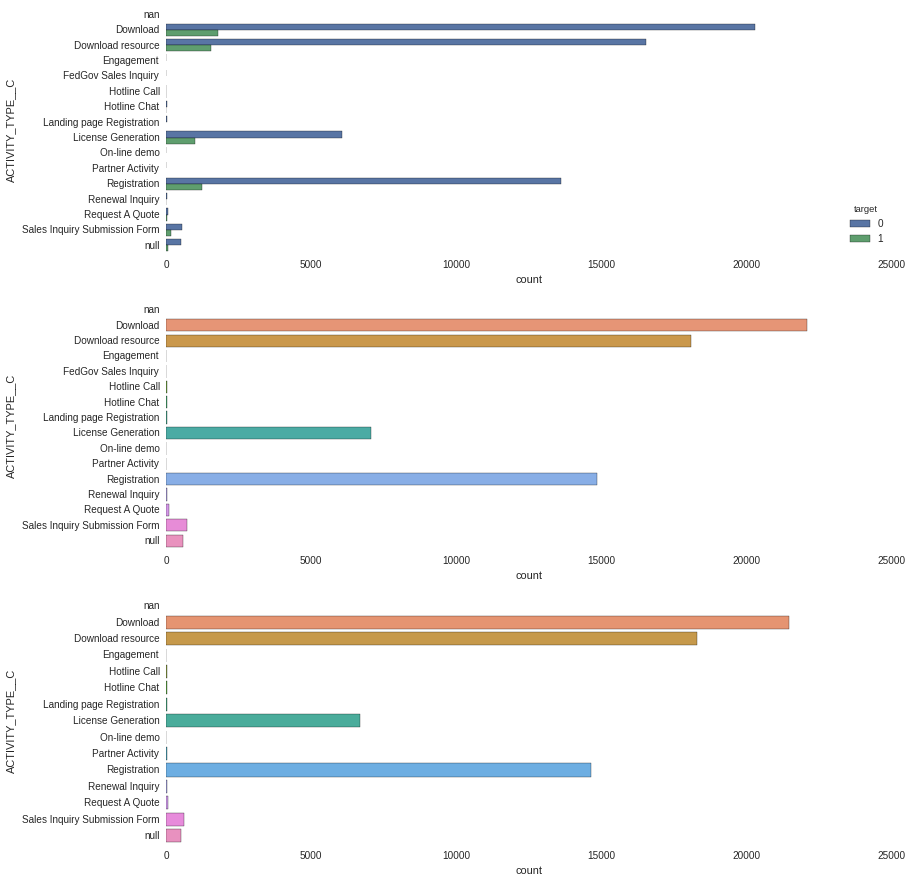

In [686]:
feature = 'ACTIVITY_TYPE__C'
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 15))
sns.countplot(y=feature, data=train, ax=ax1, hue='target', order=sorted(train[feature].unique()))
sns.countplot(y=feature, data=train, ax=ax2,  order=sorted(train[feature].unique()))
sns.countplot(y=feature, data=test, ax=ax3,  order=sorted(test[feature].unique()))
print train[feature].isnull().sum(), test[feature].isnull().sum()

In [687]:
if 'ACTIVITY_TYPE__C' in data.columns:
    top = ['Registration', 'License Generation', 'Download', 'Download resource'] 
    data['act_na'] = data.ACTIVITY_TYPE__C.isnull().astype(int)
    data['act_registration'] = (data.ACTIVITY_TYPE__C == 'Registration').astype(int)
    data['act_license'] = (data.ACTIVITY_TYPE__C == 'License Generation').astype(int)
    data['act_download'] = (data.ACTIVITY_TYPE__C == 'Download').astype(int)
    data['act_download_res'] = (data.ACTIVITY_TYPE__C == 'Download resource').astype(int)
    data['act_other'] = ((data.ACTIVITY_TYPE__C.notnull()) & 
                         (data.ACTIVITY_TYPE__C.map(lambda x: x not in top))
                        ).astype(int)
    data.drop('ACTIVITY_TYPE__C', axis=1, inplace=True)

### ACTIVITY_NAME and ACTIVITY FILENAME__C
User activity name

In [688]:
if 'ACTIVITY FILENAME__C' in data.columns:
    data.drop('ACTIVITY FILENAME__C', axis=1, inplace=True)

if 'ACTIVITY_NAME' in data.columns:
    data.drop('ACTIVITY_NAME', axis=1, inplace=True)

### CAMPAIGN.SUB_TYPE__C
User activity sub-type

106598 105307


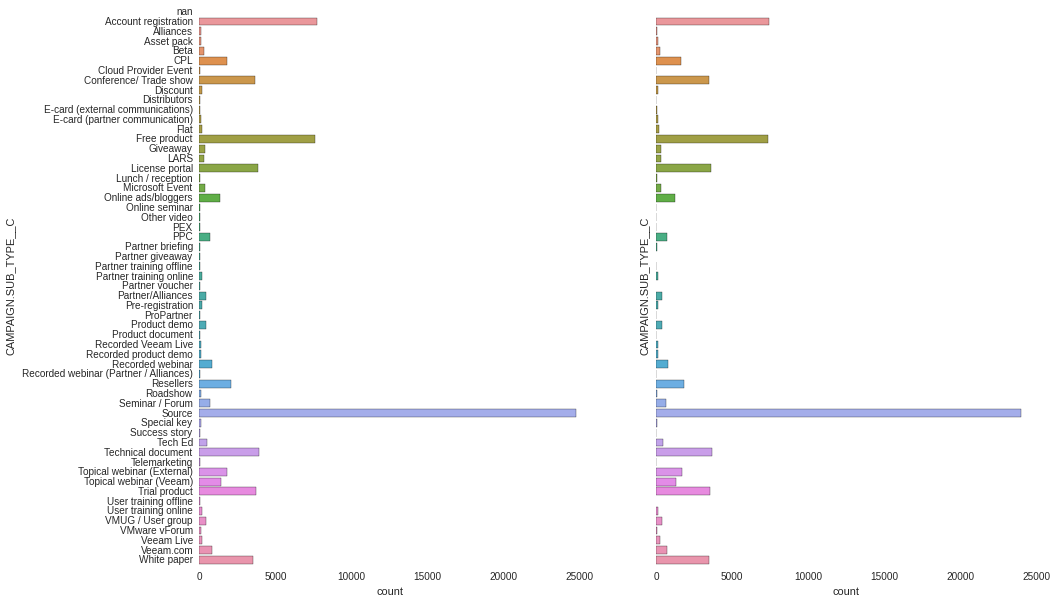

In [689]:
feature = 'CAMPAIGN.SUB_TYPE__C'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
sns.countplot(y=feature, data=train, ax=ax1, order=sorted(train[feature].unique()))
sns.countplot(y=feature, data=test, ax=ax2, order=sorted(train[feature].unique()))
print train[feature].isnull().sum(), test[feature].isnull().sum()

if feature in data.columns:
    data.drop(feature, axis=1, inplace=True)

### CAMPAIGN.TYPE
User activity type

106592 105298


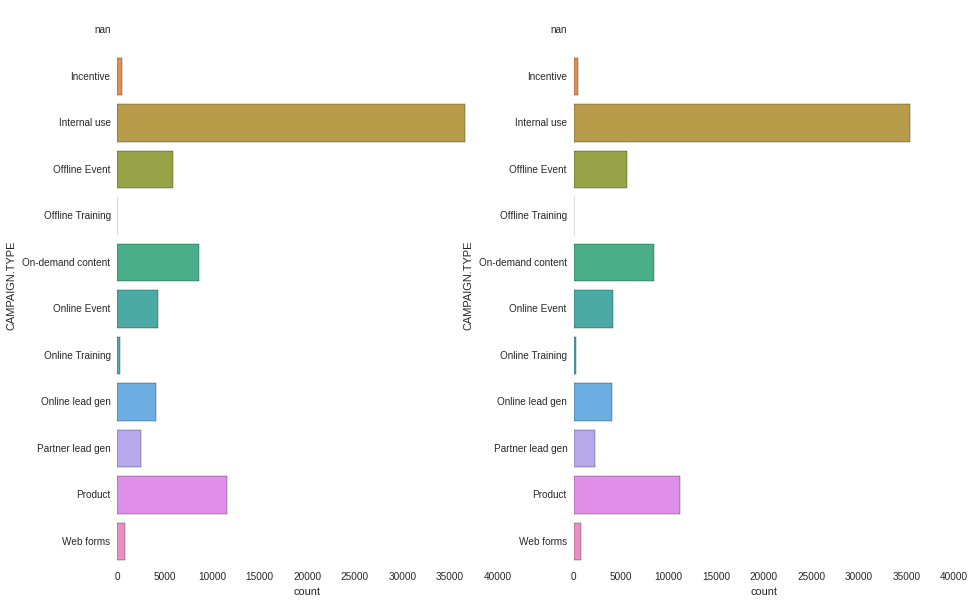

In [690]:
feature = 'CAMPAIGN.TYPE'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
sns.countplot(y=feature, data=train, ax=ax1, order=sorted(train[feature].unique()))
sns.countplot(y=feature, data=test, ax=ax2, order=sorted(train[feature].unique()))
print train[feature].isnull().sum(), test[feature].isnull().sum()

if feature in data.columns:
    data[feature].fillna('nan', inplace=True)
    data = one_hot_encode(data, [feature])
    data.drop(feature, axis=1, inplace=True)

### CAMPAIGN_DEPARTMENT
Marketing department which attracted and logged user activity

117423 115763


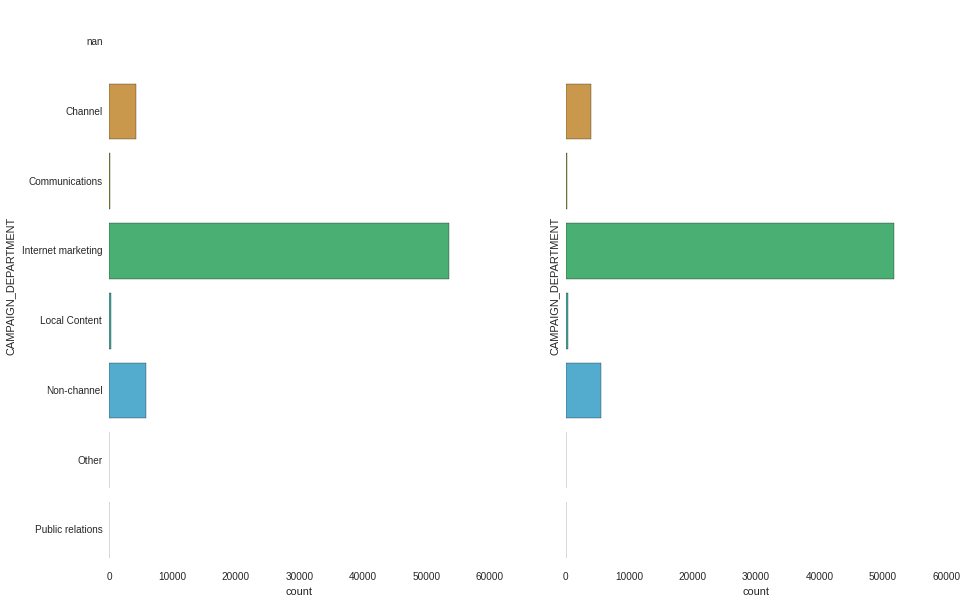

In [691]:
feature = 'CAMPAIGN_DEPARTMENT'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
sns.countplot(y=feature, data=train, ax=ax1, order=sorted(train[feature].unique()))
sns.countplot(y=feature, data=test, ax=ax2, order=sorted(train[feature].unique()))
print train[feature].isnull().sum(), test[feature].isnull().sum()

if feature in data.columns:
    data[feature].fillna('nan', inplace=True)
    data = one_hot_encode(data, [feature])
    data.drop(feature, axis=1, inplace=True)

In [692]:
data.set_value?

### ACTIVITY_NAME and ACTIVITY FILENAME__C
User activity code and User activity name

In [693]:
if 'CAMPAIGN.CAMPAIGN_CODE__C' in data.columns:
    data.drop('CAMPAIGN.CAMPAIGN_CODE__C', axis=1, inplace=True)
if 'CAMPAIGN.NAME' in data.columns:
    data.drop('CAMPAIGN.NAME', axis=1, inplace=True)

###  ИТОГО

In [694]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359572 entries, 0 to 181811
Data columns (total 46 columns):
DOMAIN                                    359572 non-null object
is_train                                  359572 non-null int64
target                                    359572 non-null int64
username                                  359572 non-null object
zipset_isnan                              359572 non-null int64
State_isnan                               359572 non-null int64
rec_cd_month                              359572 non-null float64
RECORD-TYPE_CampaignMember                359572 non-null float64
RECORD-TYPE_Customer_Activity             359572 non-null float64
RECORD-TYPE_Task                          359572 non-null float64
productlist_isnan                         359572 non-null int64
lc_cd_month                               359572 non-null float64
lc_cd_year                                359572 non-null float64
cr_byid_7MY1AAM                           3

## GROUPING

In [695]:
data.drop('username', axis=1, inplace=True)
main_data = data.groupby('DOMAIN').mean()

In [696]:
train = main_data[main_data.is_train == 1]
test = main_data[main_data.is_train == 0]
train.shape, test.shape

((22718, 44), (22357, 44))

In [697]:
x = np.array(train.drop(['target', 'is_train'], axis=1))
y = np.array(train.target)

x = np.array(train.drop(['target', 'is_train'], axis=1))
x.shape, y.shape

((22718, 42), (22718,))

## MODEL

In [698]:
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

In [699]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
print x_train.shape, x_test.shape

(18174, 42) (4544, 42)


In [700]:
model = RandomForestClassifier(n_jobs=-1, n_estimators=100)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

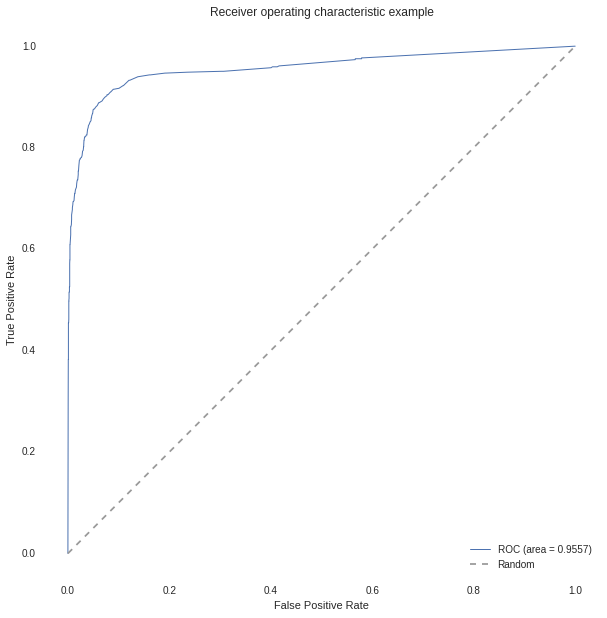

In [701]:
y_pred = model.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1])
roc_auc = auc(fpr, tpr)
fig, ax = plt.subplots(1,1, figsize=(10,10))

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.4f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

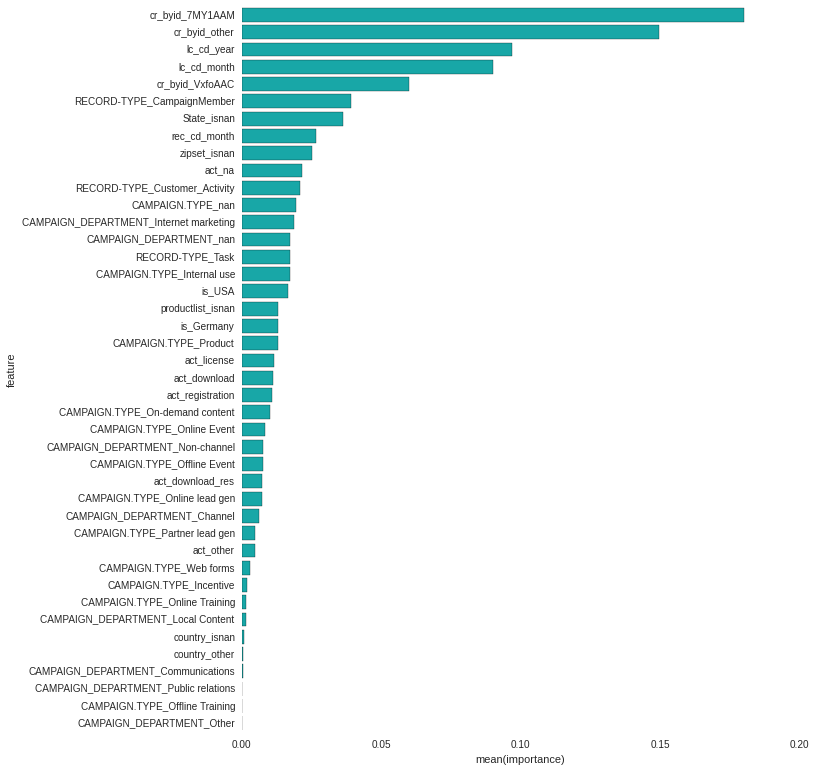

In [702]:
features = data.columns[3:]
fig, ax = plt.subplots(1,1, figsize=(10, 13))
imp = pd.DataFrame({'feature':features, 'importance':model.feature_importances_})
imp.sort('importance', inplace=True, ascending=False)
sns.barplot(y='feature', x='importance', data=imp, color='c')